## Levatamos Fermionic

In [1]:
!pip install openfermion sparse ray cupy-cuda12x cloudpickle scikit-learn openfermionpyscf

Debido al número de niveles (innecesarios) en el core, el objetivo es calcular la base natural (a partir de rho1), y proyectar el fundamental sobre el subespacio generado por los estados no ocupados. Allí, buscamos la descomposición, y luego volvemos a la base original

In [2]:
from fermionic_mbody import FixedBasis, rho_m_gen, rho_m

import numpy as np
import openfermion as of
from tqdm import tqdm
from itertools import combinations
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
import functools
import concurrent.futures
from numba import njit
import scipy
import sparse
import itertools
import linecache
from multiprocessing import Pool, cpu_count
import sympy

### Determinación de estado

#### Calculo de H

In [4]:
"""
Un método alternativo para el caso H2O para calcular los hamiltonianos en función de (d), utilizando pyscf
"""

from openfermion.chem import MolecularData
import matplotlib.pyplot as plt
import openfermionpyscf

def generate_h2o_hamiltonian(r):
    theta = np.deg2rad(104.5)
    x, z = r * np.sin(theta/2), r * np.cos(theta/2)
    geometry = [
        ('O', (0.0, 0.0, 0.0)),
        ('H', ( x, 0.0, z)),
        ('H', (-x, 0.0, z))
    ]
    
    molecule_s = MolecularData(
        geometry=geometry,
        basis='sto-3g',
        multiplicity=1,
        charge=0
    )
    
    molecule = openfermionpyscf.run_pyscf(
        molecule_s,
        run_scf=1,
        run_mp2=1,
        run_cisd=1,
        run_ccsd=1,
        run_fci=1
    )

    molecular_hamiltonian = molecule.get_molecular_hamiltonian()
    
    qubit_hamiltonian = of.jordan_wigner(molecular_hamiltonian)
    
    sparse_hamiltonian = of.get_sparse_operator(qubit_hamiltonian)
    
    return sparse_hamiltonian, molecule, molecule_s


#### Inicialización de bases y arrays básicos

In [54]:
# Base en el canónico
basis_c = FixedBasis(d=14, num=10) 

# Filtramos a los estados que tengan igual número de electrones UP / DOWN
idx_equal = [
    idx for idx, ket in enumerate(basis_c.base)
    if sum(p % 2 == 0 for p, _ in next(iter(ket.terms.keys()))) == 5
]
basis_r = FixedBasis.from_subset(basis_c, idx_equal)

# Base de 5 partículas (solo UP)
basis_up = FixedBasis(d=7, num=5) 

In [91]:
# Dado un operador, devulve los niveles UP o DOWN que tiene ocupados
def split_indices(op, basis = basis_up):
    # occupation bit-masks for the 7 up and 7 down spin-orbitals
    mask_up, mask_dn = 0, 0
    for p, _ in next(iter(op.terms.keys())):       # p = 0…13
        if p % 2 == 0:                             # even → ↑
            mask_up |= 1 << (p // 2)               # shift into 0…6
        else:                                      # odd  → ↓
            mask_dn |= 1 << (p // 2)

    i = int(np.where(basis.num_ele == mask_up)[0][0])
    j = int(np.where(basis.num_ele == mask_dn)[0][0])
    return i, j

# Devuelve C_{ij} tal que  |GS⟩ = Σ_{i,j} C_ij |UP_i⟩⊗|DOWN_j⟩."""
def vect_to_tensor_array(gs_vec, basis_r, basis_up):
    C = np.zeros((basis_up.size, basis_up.size), dtype=gs_vec.dtype)

    for k, amp in enumerate(gs_vec):
        if np.abs(amp) == 0:
            continue
        i, j = split_indices(basis_r.base[k], basis_up)
        C[i, j] = amp

    return C

"""
Dada matriz densidad de 1 cuerpo, calcula la base natural de 1 cuerpo.
Devuelve la matriz densidad en la nueva base
"""
def natural_basis_rotation(basis, rho_1 = None, U = None):
    if U is None:
        evals, evects = scipy.linalg.eigh(rho_1.todense())
        U = evects[::-1].T 

    V = np.zeros((basis.size, basis.size))
    
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))]
    i_levels = np.array([act_lvls(basis.base[i]) for i in range(basis.size)])
    j_levels = np.array([act_lvls(basis.base[j]) for j in range(basis.size)])
    
    row_indices = i_levels[:, np.newaxis, :, np.newaxis]
    col_indices = j_levels[np.newaxis, :, np.newaxis, :]

    submatrices = U[row_indices, col_indices]
    V = np.linalg.det(submatrices)
    
    return V


## Opti

Comenzamos obteniendo el fundamental

In [92]:
# Obtenemos el Hamiltoniano en el límite disociado (escrito en el GC)
h_gc, _, _ = generate_h2o_hamiltonian(3.0)
h_c = h_gc[np.ix_(basis_r.num_ele, basis_r.num_ele)].real.todense()
e, v = scipy.sparse.linalg.eigsh(h_c, k=1, which='SA', tol=1e-8)
fund = v[:, 0]

# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(fund, basis_r, basis_up)

# Arrays
rho_1_arrays = rho_m_gen(basis_up, 1)

# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)
# Matrices de cambio de base (UP DOWN) y transformacion rho -> rhon
V_up = natural_basis_rotation(basis_up, rho_1 = rho_1_up)
rhon_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis_up, rho_1 = rho_1_down)
rhon_down = V_down @ rho_down @ V_down.T
Cn = V_up @ C @ V_down.T

ρ_1: 100%|██████████| 8/8 [00:00<00:00, 37.91it/s]


In [95]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.mixture import GaussianMixture
from scipy.linalg import expm, logm

"""
Dado un estado C, busca rotaciones de un cuerpo que minimizen el número de términos presentes en el estado. Para ello
- Dado un vector seed (generador de la matriz antisimétrica), obtenemos una transformación U via exponenciación
- Calculamos el cambio de base, y la representación de rho en esa nueva base
- Calculamos el costo de la representacion
"""
# Comenzaremos con la optimización con la base natural
def rho_to_seed(rho):
    evals, evects = scipy.linalg.eigh(rho.todense())
    U = evects[::-1].T 
    return encode(U)

def encode(U):
    A = logm(U) 
    A = 0.5 * (A - A.T) 
    triu_indices = np.triu_indices(U.shape[0], k=1)
    params = A[triu_indices].real  
    return params

def decode(params):
    n = int((1 + np.sqrt(1 + 8 * len(params))) // 2) 
    A = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    A[triu_indices] = params
    A -= A.T  
    U = expm(A) 
    return U

# Funciones de costo

def hoyer_sparsity(c):
    n = c.size
    L1 = np.sum(np.abs(c))
    L2 = np.sqrt(np.sum(c**2))
    return (np.sqrt(n) - L1 / L2) / (np.sqrt(n) - 1)


def l0_combined(C, threshold=1e-3, alpha=0.1, beta=1.0, temperature=0.01):
    abs_C = np.abs(C)
    L1 = np.sum(abs_C)
    sigmoid_mask = 1 / (1 + np.exp(-(abs_C - threshold) / temperature))
    smoothed_L0 = np.sum(sigmoid_mask)
    
    return alpha * L1 + beta * smoothed_L0

def loss(C):
    """
    Distintas normas utilizadas para optimizar. Estas verifican 
    -OK1 => que loss(C) > loss(Cn)
    -OK2 => nonzero(Cn) > nonzero(Cop)
    """
    # Hoyer (OK2)
    #return 1 - hoyer_sparsity(C.flatten())
    # Norma 1 (OK1)
    #return np.linalg.norm(C, 1)
    # Norma infinito (OK1)
    # return np.max(np.sum(abs(C), axis=1))
    # Combined L0 + penalty loss (OK1) (OK2)
    return l0_combined(C)

def opti_fun(seed, C = C, basis = basis_up):
    # Decodificamos la semilla
    params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
    # Decodificamos 
    U_up, U_down = decode(params_up), decode(params_down)
    V_up, V_down = natural_basis_rotation(basis, U=U_up), natural_basis_rotation(basis, U=U_down)
    # Obtenemos la matriz de coeficientes rotada
    Ce = V_up @ C @ V_down.T
    return loss(Ce)

# Calculo de semilla
seed_up = rho_to_seed(rho_1_up)
seed_down = rho_to_seed(rho_1_down)
init_seed = np.concatenate([seed_up, seed_down])


# Optimizamos
opt_m = scipy.optimize.basinhopping(
    opti_fun,
    init_seed,
    niter=10,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={
        "method":"L-BFGS-B",
        "options":{"disp": True}
    },
)

# Rotamos el estado
seed = opt_m.x
params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:] 
U_up, U_down = decode(params_up), decode(params_down)
Vop_up, Vop_down = natural_basis_rotation(basis_up, U=U_up), natural_basis_rotation(basis_up, U=U_down)
Cop = Vop_up @ C @ Vop_down.T

In [96]:
opti_fun(init_seed), loss(Cn), loss(Cop)

(215.9044851292861, 215.90448512928606, 215.85386062174675)

In [97]:
ooo = 2
len(np.round(C,ooo).nonzero()[0]), len(np.round(Cn,ooo).nonzero()[0]), len(np.round(Cop,ooo).nonzero()[0])

(14, 10, 10)

In [36]:
loss(C), loss(Cn), loss(Cop)

(0.6465554052231335, 1.2563117316685313, 0.5255339589146002)

In [28]:
rhon_up = Cn @ np.transpose(Cn)
np.linalg.eigvals(rho_m(rhon_up, rho_1_arrays).todense())

array([1.00000004, 0.99999739, 0.99999489, 0.4806496 , 0.51935319,
       0.47487306, 0.52513204])

## Calculo de matrices densidad

rho2 (bloques)

In [ ]:
# Calculo de bloques UPUP UPDOWN

t_basis = FixedBasis(basis_total.d, 2)
upup_terms = []
updown_terms = []
for idx, t in enumerate(t_basis.base):
    act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
    if np.all(act_lvls(t) < 7):
        upup_terms.append(idx)
    if act_lvls(t)[0] < 7 and act_lvls(t)[1] > 6:
        updown_terms.append(idx)

def extract_sparse_block(arr, row_terms, col_terms):
    """Extract subarray from sparse COO using term indices for first two dimensions"""
    # Create coordinate masks
    row_mask = np.isin(arr.coords[0], row_terms)
    col_mask = np.isin(arr.coords[1], col_terms)
    combined_mask = row_mask & col_mask
    
    # Get filtered coordinates and data
    filtered_coords = arr.coords[:, combined_mask]
    filtered_data = arr.data[combined_mask]
    
    # Remap indices to new dimensions
    row_map = {v:i for i,v in enumerate(row_terms)}
    col_map = {v:i for i,v in enumerate(col_terms)}
    
    # Transform coordinates
    new_coords = np.stack([
        np.array([row_map[c] for c in filtered_coords[0]]),
        np.array([col_map[c] for c in filtered_coords[1]]),
        filtered_coords[2],
        filtered_coords[3]
    ])
    
    # Create new sparse array
    return sparse.COO(
        new_coords,
        filtered_data,
        shape=(len(row_terms), len(col_terms), arr.shape[2], arr.shape[3]))
    
rho_2_upup_arrays = extract_sparse_block(rho_2_total_arrays, upup_terms, upup_terms)
rho_2_updown_arrays = extract_sparse_block(rho_2_total_arrays, updown_terms, updown_terms)


In [7]:
def rho_2_ext_process_chunk(args):
    chunk, basis, d, fact = args
    indices = []
    values = []
    
    for i, j, k, l in chunk:
        i, j, k, l = int(i), int(j), int(k), int(l)
        op1 = of.FermionOperator((k, 1)) * of.FermionOperator((l + fact, 1))
        op2 = of.FermionOperator((j + fact, 0)) * of.FermionOperator((i, 0))

        op = of.transforms.normal_ordered(op1 * op2)
        mat = np.real(of.get_sparse_operator(op, n_qubits=2 * d))[np.ix_(basis.num_ele, basis.num_ele)]
        
        # Extraemos la información
        n_r, n_c = mat.nonzero()
        data = mat.data
        for r, c, v in zip(n_r, n_c, data):
            indices.append([i * d + j, k * d + l, r, c])  # Indexamos la mat de d^2 x d^2
            values.append(v)

    return indices, values


def rho_2_gen_ext(basis, upup=True, num_workers=None):
    if num_workers is None:
        num_workers = cpu_count()  # Use all available CPUs by default

    d = basis.d // 2
    shape = (d**2, d**2, basis.size, basis.size)
    fact = 0 if upup else d

    # Split the work into chunks
    it_set = list(itertools.product(range(d), repeat=4))
    chunks = np.array_split(it_set, num_workers)

    # Prepare arguments for each worker
    worker_args = [(chunk, basis, d, fact) for chunk in chunks]

    # Use a multiprocessing Pool to parallelize the computation
    indices = []
    values = []
    with Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(rho_2_ext_process_chunk, worker_args), total=num_workers))

    # Aggregate results from all workers
    for indices_chunk, values_chunk in results:
        indices.extend(indices_chunk)
        values.extend(values_chunk)

    # Construct the sparse array
    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t


rho_2_extended_up = rho_2_gen_ext(basis_total, upup = True)
rho_2_extended_updown  = rho_2_gen_ext(basis_total, upup = False)

100%|██████████| 12/12 [02:28<00:00, 12.35s/it]


In [8]:
# Operaciones sobre matrices
def partial_traspose(rho, perm, upup = True):
    d = basis.d
    rho_p = np.zeros((d**2, d**2))
    f = 0 if upup else d
    for m in range(d**2):
        for n in range(d**2):
            # Escrimos los índices i j k l en términos de m n
            i, j = m//d, m % d
            k, l = n//d, n % d
            indices = (i, j, k, l)
            ip, jp, kp, lp = tuple(indices[p] for p in perm)
            rho_p[m,n] = rho[ip*d + jp, kp*d + lp]
    return rho_p

##### Ploteo

100%|██████████| 131/131 [00:01<00:00, 127.36it/s]


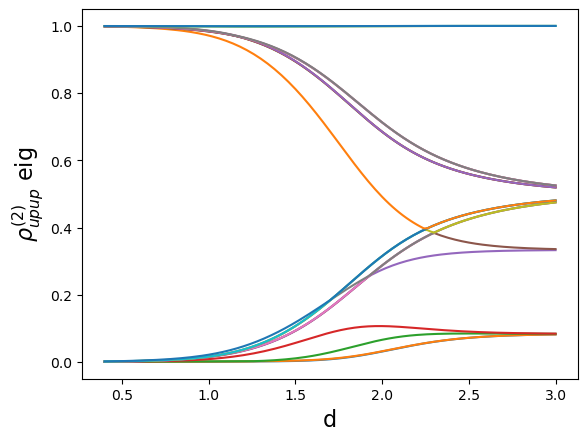

 14%|█▎        | 18/131 [00:00<00:04, 27.87it/s]/tmp/ipykernel_36865/3184034531.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idx] = np.sort(np.linalg.eigvals(rho.todense()))
100%|██████████| 131/131 [00:04<00:00, 29.83it/s]


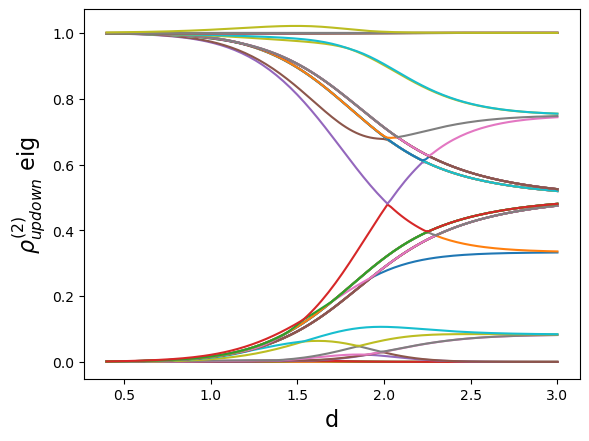

100%|██████████| 131/131 [00:14<00:00,  8.99it/s]


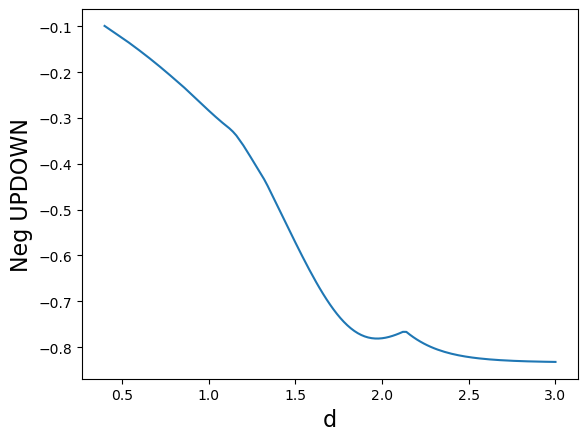

  0%|          | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_36865/3184034531.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])
100%|██████████| 131/131 [00:22<00:00,  5.88it/s]


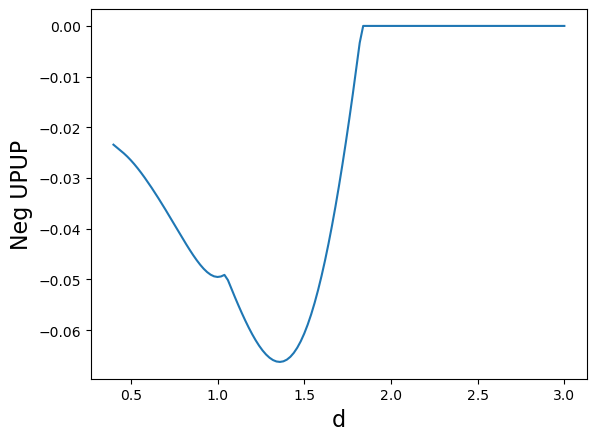

In [121]:
import matplotlib.pyplot as plt

def plot_rho(vects, rho_arrays, label = r'$\rho^{(m)}$ eig'):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds),rho_arrays.shape[0]))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        res[idx] = np.sort(np.linalg.eigvals(rho.todense()))

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def m_entropy(vects, rho_arrays):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        eigvals = np.sort(np.linalg.eigvals(rho.todense()))
        res[idx] = -np.sum([x * np.log2(x) for x in eigvals])
    return res / np.trace(rho.todense())

def plot_neg(vects, rho_arrays, label = r'$\rho^{(m)}$ eig', second = False):
    ds = list(vects.keys())
    res = np.zeros(shape=(len(ds)))
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        vect = vects[d]
        rho = rho_m(vect, rho_arrays)
        second_term = partial_traspose(rho, [0, 2, 3, 1]) if second else 0
        rho = partial_traspose(rho, [0, 3, 2, 1]) - second_term
        #print(np.sort(np.linalg.eigvals(rho)))
        res[idx] = np.sum([x for x in np.linalg.eigvals(rho) if x<0])

    plt.plot(ds, res)
    plt.xlabel(r'd', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

#plot_rho(vects, rho_1_total_arrays, label = r'$\rho^{(1)}$ eig')
#plot_rho(vects, rho_2_total_arrays, label = r'$\rho^{(2)}$ eig')
plot_rho(vects, rho_2_upup_arrays, label = r'$\rho^{(2)}_{upup}$ eig')
plot_rho(vects, rho_2_updown_arrays, label = r'$\rho^{(2)}_{updown}$ eig')
plot_neg(vects, rho_2_extended_updown, label = r'Neg UPDOWN')
plot_neg(vects, rho_2_extended_up, label = r'Neg UPUP', second = True)

ds = list(vects.keys())
#plt.plot(ds, m_entropy(vects, rho_1_total_arrays),label='Total (1)')
#plt.plot(ds, m_entropy(vects, rho_2_total_arrays),label='Total (2)')
#plt.plot(ds, m_entropy(vects, rho_2_upup_arrays), label='UPUP')
#plt.plot(ds, m_entropy(vects, rho_2_updown_arrays), label='UPDOWN')
#plt.legend()
#plt.show()


In [122]:
_, v, _ = np.linalg.svd(C)
v**2

array([3.35816414e-01, 3.32617106e-01, 8.42477074e-02, 8.36604703e-02,
       8.18321762e-02, 8.18187409e-02, 1.58602113e-06, 1.41411075e-06,
       9.55689442e-07, 8.83852767e-07, 8.20073112e-07, 7.78341846e-07,
       5.36293600e-07, 4.51065028e-07, 9.08681275e-11, 8.16442864e-11,
       5.48197463e-11, 4.73083233e-11, 6.21741154e-12, 1.11151399e-15,
       4.70564364e-16])

## Análisis H

In [9]:
# Generamos el H para d=4
H_sparse, molecule, molecule_s = generate_h2o_hamiltonian(4)
# Restringimos a la base canónica
H_sparse = H_sparse[np.ix_(basis_c.num_ele, basis_c.num_ele)].real
# También levantamos el H que nos dió Javier, cuidado con la base
#H_jav = np.loadtxt('H.txt')

In [ ]:
# Filtramos a los estados que tengan igual número de electrones UP / DOWN
idx_set = []
for idx, vect in enumerate(basis_c.base):
    act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
    if len(np.where(act_lvls(vect) % 2 == 0)[0]) == basis_c.m//2:
        idx_set.append(idx)
idx_set = np.array(idx_set)

H = H_sparse[np.ix_(idx_set, idx_set)].todense()
# Guardamos la base restringida
basis_r = FixedBasis(basis_c.d, basis_c.m, pairs = False, basis = np.array(basis_c.base)[idx_set], num_ele=np.array(basis_c.num_ele)[idx_set])
rho_1_arrays_r = rho_m_gen(basis_r, 1)
rho_2_arrays_r = rho_m_gen(basis_r, 2)

100%|██████████| 12/12 [08:24<00:00, 42.04s/it]  


In [11]:
f = np.array(eigen_space[:,0]).reshape(-1)
rrr = rho_m(f, rarr)
np.linalg.eigvals(rrr.todense())

NameError: name 'eigen_space' is not defined

In [12]:
# Veamos los primeros autovalores
eigvals, eigvects = np.linalg.eigh(H)
# Levantamos el autoespacio fundamental
tol = 1e-2
idx = np.where(eigvals < min(eigvals)+tol)
dimension = len(idx[0])
eigen_space = eigvects[:,idx[0]]

def purity(coefs):
    vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect *= 1/np.linalg.norm(vect)
    vect = vect.T[0]
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return basis_r.m-np.trace(np.linalg.matrix_power(rho_1, 2))

def decomp(coefs):
    vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect *= 1/np.linalg.norm(vect)
    vect = vect.T[0]
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return 1-np.trace(np.linalg.matrix_power(rho_1, 2))


#opt = scipy.optimize.minimize(purity, np.random.rand(dimension))
#opt, opt.x

Verificamos que el autoespacio tenga el spin correcto

In [ ]:
import openfermion as of
import numpy as np
from scipy.sparse.linalg import eigsh
bbb = basis_r

# This assumes you have num_orbitals, num_electrons already defined
sz_op = of.hamiltonians.sz_operator(bbb.d//2)
s2_op = of.hamiltonians.s_squared_operator((1+bbb.d)//2)

sz_op = of.get_sparse_operator(sz_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]
s2_op = of.get_sparse_operator(s2_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]

for i in range(eigen_space.shape[1]):
    state = eigen_space[:,i]
    exp_S2 = np.real(state.conj().T @ (s2_op @ state))
    exp_Sz = np.real(state.conj().T @ (sz_op @ state))
    print(f"Estado {i}: <S^2> = {float(exp_S2):.4f}, <S_z> = {float(exp_Sz):.4f}")


Estado 0: <S^2> = 0.0005, <S_z> = 0.0000
Estado 1: <S^2> = 2.0000, <S_z> = 0.0000
Estado 2: <S^2> = 0.0003, <S_z> = 0.0000
Estado 3: <S^2> = 1.9997, <S_z> = 0.0000
Estado 4: <S^2> = 2.0000, <S_z> = 0.0000
Estado 5: <S^2> = 0.0010, <S_z> = 0.0000
Estado 6: <S^2> = 2.0000, <S_z> = 0.0000
Estado 7: <S^2> = 5.9996, <S_z> = 0.0000
Estado 8: <S^2> = 5.9999, <S_z> = 0.0000
Estado 9: <S^2> = 2.0000, <S_z> = 0.0000
Estado 10: <S^2> = 2.0001, <S_z> = 0.0000
Estado 11: <S^2> = 5.9988, <S_z> = 0.0000


/tmp/ipykernel_12783/716903050.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Estado {i}: <S^2> = {float(exp_S2):.4f}, <S_z> = {float(exp_Sz):.4f}")


Utilizamos L-BFGS-B para buscar mínimos locales, a partir de distintas semillas. Con una colección de estos, nos fijamos el rango de subespacio. Antes utilizamos shgo, pero subcontaba la cantidad de mínimos

In [13]:
maxiter = 50
local_minima_arr = []

for i in tqdm(range(maxiter)):
    seed = np.random.uniform(-1,1,dimension)
    seed *= 1/np.linalg.norm(seed)
    opt = scipy.optimize.minimize(purity, seed, method='L-BFGS-B')
    if purity(opt.x) < 1e-4:
        local_minima_arr.append(opt.x)

local_minima_arr = np.array(local_minima_arr).T # [:, i] i-esimo vector
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]]


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


In [14]:
purity_space

array([[-0.57513462, -0.03516632, -0.06068078,  0.0309668 , -0.13499611,
         0.55773039],
       [ 0.10876082,  0.15278669,  0.32715892,  0.54227879,  0.4130084 ,
         0.22725227],
       [ 0.02593562,  0.13291264, -0.35580197,  0.5604222 , -0.42930783,
        -0.14664449],
       [-0.53398172, -0.32765165,  0.35033454,  0.1701595 , -0.01530515,
        -0.5463331 ],
       [-0.44915237,  0.39871837, -0.27456038, -0.0489364 ,  0.38688255,
        -0.37154316],
       [-0.0381922 ,  0.55839283,  0.44934875, -0.13214453, -0.35661914,
        -0.04057575],
       [-0.00470196,  0.00766055,  0.02385209,  0.03636377,  0.02871316,
         0.00316526],
       [-0.00936723, -0.39923924, -0.32421143,  0.09705151,  0.24429596,
         0.06408185],
       [ 0.0286563 ,  0.09707123, -0.24956311,  0.39647796, -0.30346781,
        -0.11426344],
       [ 0.01786572,  0.08223037,  0.26657358,  0.40606626,  0.30057039,
         0.10280034],
       [-0.0308749 ,  0.45112209, -0.35102623, -0.

In [20]:
eigen_space[:,0]

matrix([[ 9.07848326e-10],
        [-4.66871078e-11],
        [-1.00588758e-08],
        [-2.19409633e-08],
        [-7.53023508e-07],
        [-6.61014198e-08],
        [ 4.66871821e-11],
        [ 1.00588758e-08],
        [ 2.19409636e-08],
        [ 7.53023511e-07],
        [ 6.61014196e-08],
        [ 1.09984398e-09],
        [-3.38389698e-10],
        [ 5.84371020e-07],
        [-2.42165055e-08],
        [-3.03532336e-08],
        [ 3.38389587e-10],
        [-5.84371022e-07],
        [ 2.42165054e-08],
        [ 3.03532340e-08],
        [-7.65392979e-11],
        [-6.85404359e-12],
        [ 4.78291124e-09],
        [ 4.25537421e-10],
        [ 6.85401562e-12],
        [-4.78291143e-09],
        [-4.25537491e-10],
        [ 2.41562424e-09],
        [-2.73011891e-11],
        [-1.11803844e-10],
        [ 2.73011613e-11],
        [ 1.11803788e-10],
        [ 2.39252398e-09],
        [ 1.98142450e-10],
        [-1.98142378e-10],
        [-1.13153584e-10],
        [ 2.09941752e-09],
 

In [35]:
v = np.sum([purity_space[k,0] * eigen_space[:,k] for k in range(purity_dim)], axis=0)
rho = partial_traspose(v, [0, 1, 2, 3]) 

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
rho_2_extended_updown  = rho_2_gen_ext(basis_r, upup = False)

100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


In [49]:
purity_space.shape, eigen_space.shape

((12, 6), (441, 12))

In [73]:
opp.shape

(441, 441)

In [72]:
pp_idx = np.zeros((6,441))
for i in range(6):
    pp_idx[i] = np.sum([purity_space[k,i] * eigen_space[:,k] for k in range(12)], axis=0).flatten()

A = np.array(pp_idx).T
opp = A @ np.linalg.inv(A.T @ A) @ A.T

np.round(opp,4)

array([[ 0., -0., -0., ..., -0.,  0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0., -0.],
       ...,
       [-0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       [ 0., -0., -0., ...,  0., -0.,  0.]])

In [102]:
diag_elem = np.where(np.abs(opp) > 1e-1)[0]
for i in range(6):
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))] # Consistente con lo anterior
    print(6.5-np.array(act_lvls(basis_r.base[diag_elem[i]]))/2)
    #print(basis_r.base[diag_elem[i]])


[6.5 6.  5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.5 5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.  4.5 4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.5 6.  5.5 4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 5.  4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 4.5 4.  3.5 3.  2.  1.  0.5 0. ]


In [ ]:
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]]

coefs = np.sum([1 * purity_space[:,i] for i in range(purity_dim)], axis=0)
vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
vect = np.array(vect).flatten()
vect *= 1/np.linalg.norm(vect)


# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)

# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C

#rho = rho_m(vect, rho_2_extended_updown)
#rho = partial_traspose(rho, [0, 3, 2, 1]) 
#print(np.sort(np.linalg.eigvals(rho)))



In [ ]:
def decomp(coefs):
    coefs = np.sum([coefs[i] * purity_space[:,i] for i in range(purity_dim)], axis=0)
    vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect = vect.T[0]
    vect *= 1/np.linalg.norm(vect)
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return 1-np.trace(np.linalg.matrix_power(rho_1, 2))

opt2 = scipy.optimize.minimize(decomp, np.random.rand(purity_dim))
ooo = opt2.x
print(opt2)
ooo *= 1/np.linalg.norm(ooo)
print(ooo)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.999999778160634
        x: [ 1.041e+00  1.335e+00  2.288e-06  5.717e-01  7.936e-07
            -6.305e-07]
      nit: 6
      jac: [ 0.000e+00  4.768e-07  7.153e-07  0.000e+00  4.768e-07
            -8.345e-07]
 hess_inv: [[ 1.274e+00  3.514e-01 ... -6.656e-02 -1.304e-02]
            [ 3.514e-01  1.451e+00 ... -8.613e-02 -1.564e-02]
            ...
            [-6.656e-02 -8.613e-02 ...  4.171e-01  2.714e-01]
            [-1.304e-02 -1.564e-02 ...  2.714e-01  5.390e-01]]
     nfev: 77
     njev: 11
[ 5.82635519e-01  7.47071848e-01  1.28071271e-06  3.20030477e-01
  4.44251153e-07 -3.52981057e-07]


Transpuesta parcial sobre el proyector al autoespacio. Recordar que utilizamos la convención de OF, donde los índices pares son UP y los impares DOWN

In [ ]:
from sympy.combinatorics import Permutation



# Reescribimos los elementos de la base en términos de productos tensorial
up_lvls = []
down_lvls = []
act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
for op in basis_r.base:
    up_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 0)))
    down_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 1)))

# Filtramos los elemetos únicos, obteniendo la base de un lado del producto tensorial
u_up_lvls = np.array(list(set(up_lvls)))
u_down_lvls = np.array(list(set(down_lvls)))

# Obtenemos la matrix C_{\mu\nu}
def tensor_decomp(state):
    s = len(u_up_lvls)
    C = np.zeros((s,s))
    act_to_int = lambda x: np.sum([2**i for i in x])
    for i, j in itertools.product(range(s), repeat=2):
        targ_state_pre = np.concatenate([u_up_lvls[i], u_down_lvls[j]])
        targ_state = tuple(sorted(targ_state_pre))
        r_idx = np.where(basis_r.num_ele == act_to_int(targ_state))[0]
        # Calculamos el signo de la permutación al sortearlos
        perm = np.argsort(targ_state_pre)
        p = Permutation(list(perm))
        sign = p.signature()
        C[i, j] = sign * state[r_idx]

    return C

def partial_transpose(C):
    s = len(u_up_lvls)
    res = np.zeros((s**2,s**2))
    for mu, nu, mup, nup in itertools.product(range(s), repeat=4):
        i = s * mu + nu
        j = s * mup + nup
        res[i, j] = C[mu, nup] * C[mup, nu]
    return res

pt = lambda x: partial_transpose(tensor_decomp(x))
mat = np.sum([pt(eigen_space[:,i]) for i in range(dimension)], axis=0)
np.sort(np.linalg.eigvals(mat))

/tmp/ipykernel_36865/1646309796.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C[i, j] = sign * state[r_idx]


array([-9.99999916e-01, -9.99999916e-01, -1.87175042e-04, -1.87171684e-04,
       -1.73404358e-04, -1.73238279e-04, -1.64250726e-04, -1.63960241e-04,
       -9.84856530e-05, -9.82899512e-05, -9.78538435e-05, -9.77073882e-05,
       -9.68740766e-05, -9.68719231e-05, -8.21697720e-05, -8.21690267e-05,
       -7.83072212e-05, -7.83010724e-05, -7.42543531e-05, -7.42281399e-05,
       -1.24041319e-05, -1.21150203e-05, -1.07390199e-05, -1.05004889e-05,
       -6.70333511e-06, -6.34326468e-06, -5.99758925e-06, -5.97232319e-06,
       -5.37842435e-06, -5.36733577e-06, -4.65190701e-06, -4.30078724e-06,
       -1.14180677e-06, -1.14012386e-06, -9.11831809e-07, -9.01436774e-07,
       -7.13688950e-07, -7.04671947e-07, -5.03235337e-07, -5.03204819e-07,
       -5.03101015e-07, -5.02740112e-07, -5.02437031e-07, -5.00583784e-07,
       -4.49978505e-07, -4.48570345e-07, -4.41402278e-07, -4.35850725e-07,
       -4.30319891e-07, -4.29443585e-07, -3.07377998e-07, -2.85751367e-07,
       -2.11721309e-07, -

# Misc

Opt global

In [3]:
ds = list(vects.keys())[::10]
res = np.zeros(shape=(len(ds),3))
for idx, d in tqdm(enumerate(ds), total=len(ds)):
    loss = lambda au: np.linalg.norm(au, 1)
    vect = vects[d]
    # Estado sin transformar
    C = vect_to_tensor_array(basis, vect)
    res[idx,0] = loss(C)
    # Estado en base natural
    rho_up = C @ np.transpose(C)
    rho_down = np.transpose(C) @ C
    rho_1_up = rho_m(rho_up, rho_1_arrays)
    rho_1_down = rho_m(rho_down, rho_1_arrays)
    V_up = natural_basis_rotation(basis, rho_1 = rho_1_up)
    V_down = natural_basis_rotation(basis, rho_1 = rho_1_down)
    Cn = V_up @ C @ V_down.T
    res[idx,1] = loss(Cn)
    # Optimizamos
    expt_len = basis.d * (basis.d + 1) // 2
    triu_rows, triu_cols = np.triu_indices(basis.d)
    init_seed_up, init_seed_down = V_up[triu_rows, triu_cols], V_down[triu_rows, triu_cols]
    init_seed = np.concatenate([init_seed_up, init_seed_down])
    opt = scipy.optimize.minimize(opti_fun, init_seed, method='L-BFGS-B', options={'disp': True}, args=(C, basis))
    seed = opt.x
    seed_up, seed_down = seed[:expt_len], seed[expt_len:]
    Vop_up, Vop_down = seed_to_rotation(seed_up), seed_to_rotation(seed_down)
    Cop = Vop_up @ C @ Vop_down.T
    res[idx,2] = loss(Cop)

res = res.T

NameError: name 'vects' is not defined

In [ ]:
import matplotlib.pyplot as plt
res = res.T
plt.pyplot.plot(ds, res[0], label='Estado')
plt.pyplot.plot(ds, res[1], label='Base natural')
plt.pyplot.plot(ds, res[2], label='Optimizado')
plt.pyplot.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

In [ ]:
norm1 = lambda au: np.sum(np.abs(au))
norm2 = lambda au: np.max

In [ ]:
def cost(au):
    return np.linalg.norm(au, ord=1)

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.6030561514836338, 0.6050418638279407)

In [ ]:
np.trace(rhoo_up)

1.0000000406850609

Veamos que ocurre ahora con la matriz de coeficientes

In [ ]:
cost = lambda au: np.max(np.sum(np.abs(au), axis=0))

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.9191059397990166, 0.5485164931466948)

In [ ]:
np.round(Cn,5).nonzero(), np.round(C,5).nonzero()

((array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,

In [ ]:
np.linalg.norm(rho_up-rhon_up), np.linalg.norm(rho_up-rhoo_up)

(0.34206023774207855, 0.015398804494478627)

In [ ]:
Cn

array([[-9.28164239e-03, -4.46010991e-02,  1.98770844e-03,
         1.12637076e-03,  4.83222874e-02,  2.09218992e-01,
        -6.87161227e-06, -2.94053351e-04,  9.19167665e-05,
        -8.81515231e-08,  9.98141372e-04,  4.44739298e-02,
         1.92547642e-01, -2.00574483e-04,  1.30140475e-06,
        -6.19631382e-06, -2.65156436e-04,  8.22383181e-05,
        -7.95612501e-08,  3.86674330e-11, -1.17359343e-06],
       [-2.02232733e-03,  1.43622010e-04,  2.09550437e-03,
         2.12130637e-01,  4.88637137e-03, -6.34054817e-04,
        -5.86450796e-05,  5.12685543e-06, -1.60728233e-07,
        -6.43177712e-04,  1.95228994e-01,  4.49727492e-03,
        -5.92258989e-04, -2.58660179e-05,  5.91937808e-04,
        -5.40017757e-05,  4.60137264e-06, -1.41186830e-07,
        -5.78547571e-04, -5.65948653e-07, -5.32456614e-04],
       [-4.55575504e-02,  3.96083234e-03, -2.62208130e-04,
         4.87186654e-03,  4.21116237e-01, -2.71044864e-02,
         2.21344247e-06,  3.59376282e-05, -6.51758419e

In [ ]:
np.round(rhon_up,3)

array([[ 0.086,  0.001,  0.024, -0.016, -0.   ,  0.001,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001,  0.083,  0.001, -0.007,  0.001, -0.   , -0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.024,  0.001,  0.332,  0.   , -0.002,  0.002,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.016, -0.007,  0.   ,  0.333,  0.005, -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.001, -0.002,  0.005,  0.083, -0.001, -0.   ,  0.   ,
        -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001, -0.   ,  0.002, -0.

In [ ]:
"""
Algunos casos de ejemplo para ver de como funciona la rotación de bases
"""
# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)
# Calculamos las matrices de densidad reducidas UP, DOWN
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

V_up = natural_basis_rotation(basis, rho_1_up, rho_up)
rhot_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis, rho_1_down, rho_down)
rhot_down = V_down @ rho_down @ V_down.T

np.linalg.eigvals(rho_m(rhot_up, rho_1_arrays).todense()), np.linalg.eigvals(rho_m(rhot_down, rho_1_arrays).todense())

100%|██████████| 21/21 [00:00<00:00, 23.98it/s]


(array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]),
 array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]))

In [33]:
basis_c.m

10

In [ ]:
print(opt)
print(opt.x)
print(sparsity_error(opt.x, k=k))
print(rho_2_obj)
np.round(r_eig(rho_m(opt.x, rho_2_arrays)),2)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.033046434440661125
        x: [-3.375e-09 -6.560e-09 ... -2.341e-06 -2.501e-01]
      nit: 6
      jac: [ 2.845e-08 -2.429e-08 ... -3.317e-05 -3.462e-03]
     nfev: 16570
     njev: 10
 hess_inv: <1656x1656 LbfgsInvHessProduct with dtype=float64>
[-3.37476985e-09 -6.55962993e-09 -2.46507721e-09 ... -3.19263831e-09
 -2.34107673e-06 -2.50086415e-01]
0.03302971629150185
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.67, 0.67, 0.67, 0.67, 0.67,
       0.67, 0.67, 0.67, 0.67, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [ ]:
final_res = of.FermionOperator.zero()

tol = 1e-3
for idx, coord in enumerate(opt.x):
    final_res += basis_pro.base[idx] * coord if np.abs(coord) > tol else 0
    if np.abs(coord) > tol:
        print((1/np.abs(coord)**2))

#final_res, unique_ele(final_res)
res_round = np.sum([basis_pro.base[idx] * 1/np.sqrt(np.round(1/coord**2)) for idx, coord in enumerate(opt.x) if np.abs(coord) > tol])
vect_round = op_to_rep(basis_pro, res_round)
r_eig(rho_m(vect_round, rho_1_arrays)), rho_1_obj


15.985149014125556
15.977994228992863
145.67794611307684
144.23635285020111
36.0667153166155
36.06669576174053
144.236519674107
145.67809058988465
15.940732217777308
15.92062248719232
36.06161200056504
144.19110686510734
145.6825136168376
144.3651909188651
36.137913817300415
144.15515590265179
36.08996734303805
146.12453205723767
145.9487386480123
36.0045807486866
143.95252252055505
145.46009050066652
145.68262967629167
144.19109509086093
36.06156842879171
146.12428332738412
145.94902938020775
36.13796198870655
144.36575578324243
36.089955665595035
144.15460190992823
145.46007040730746
143.95261481327165
36.00458940655681
15.941719440781728
15.91950923819659
145.45631237154984
143.99620720608377
36.00963579334049
36.009636612591606
143.99642927360614
145.45649058176977
15.951017099193605
15.988944628712272


(array([0.49947646, 0.49947646, 0.49947646, 0.49947646, 0.4995237 ,
        0.4995237 , 0.4995237 , 0.4995237 , 0.49957093, 0.49957093,
        0.49957093, 0.49957093, 0.99904739, 0.99904739, 0.99904739,
        0.99904739]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
        1. , 1. , 1. ]))

#### Testing

Verificamos que los eig de rho1 se preservan

In [ ]:
# Cálculo de base natural
rho_1_arrays = rho_m_gen(basis, 1)
rho_1 = rho_m(vect, rho_1_arrays).todense()
evals, evects = scipy.linalg.eigh(rho_1)
C = evects

res, vect_op_ft = natural_basis_rotation(basis, C, vect)

ext_basis = FixedBasis(basis.d, basis.m)
rho_1_arrays_n = rho_m_gen(ext_basis, 1, num_workers=32)
rho_1_n = rho_m(res, rho_1_arrays_n).todense()
print(np.trace(rho_1_n), np.trace(rho_1))

evv = lambda vv: np.sort(np.real(np.linalg.eigvals(vv)))
print(evv(rho_1), evv(rho_1_n))

rep_to_op = lambda vect: np.sum([vect[i] * basis.base[i] for i in range(len(vect))])
#unique_ele(vect_op_ft), unique_ele(rep_to_op(vect))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.54s/it]


10.000000000000002 10.000000406850612
[0.         0.         0.47487306 0.47487306 0.4806496  0.4806496
 0.51935319 0.51935319 0.52513204 0.52513204 0.99999489 0.99999489
 0.99999739 0.99999739 1.00000004 1.00000004] [0.         0.         0.47487306 0.47487306 0.48064955 0.48064955
 0.51935319 0.51935319 0.525132   0.525132   0.99999485 0.99999485
 0.99999735 0.99999735 1.         1.        ]


Verificamos que la composición, es la identidad

In [ ]:
res, vect_op_ft = natural_basis_rotation(basis, C, vect)
res2, vect_op_ft2 = natural_basis_rotation(ext_basis, C.T, res)

vect_op = np.sum([vect[i] * basis.base[i] for i in range(len(vect))])

of.transforms.normal_ordered(vect_op_ft2), res2, of.transforms.normal_ordered(vect_op)

(-0.009493221505521588 [11^ 10^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.06567915392863352 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +
 -0.00039479040463999686 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 0^] +
 -3.372243029427183e-06 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 1^] +
 -0.046493134167591176 [11^ 10^ 9^ 8^ 7^ 6^ 3^ 2^ 1^ 0^] +
 -0.28426333153569405 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 2^ 1^ 0^] +
 -0.00013174919476567257 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 0^] +
 3.4219639201432875e-07 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 1^] +
 0.002101619231354521 [12^ 10^ 9^ 8^ 7^ 5^ 3^ 2^ 1^ 0^] +
 0.2881444085777637 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 2^ 1^ 0^] +
 -7.974636812387609e-05 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 0^] +
 -2.402101031541447e-06 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 1^] +
 0.0011760974915812092 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 0^] +
 8.012654141343571e-06 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 1^] +
 5.654427524408164e-07 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 3^ 2^] +
 0.06567916523926123 [12^ 11^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.00389332162644885 [12^ 11^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +


Funciones auxiliares

In [ ]:
def unique_ele(op):
    terms = list(op.terms.items())
    act_idx = lambda tt: [i[0] for i in tt[0]]
    terms_set = []
    for term in terms:
        if np.abs(term[1]) > 1e-6:
            terms_set.append(act_idx(term))
    return set(terms_set[0]).intersection(*terms_set[1:])

unique_ele(op_pro), unique_ele(op_fund)

(set(), set())

In [ ]:
np.linalg.eigvals(rho_1)

array([0.97351211, 0.92118047, 0.31511585, 0.31511585, 0.79019157,
       0.79019157, 1.        , 0.97351211, 0.92118047, 1.        ,
       1.        , 1.        ])

In [ ]:
# Verifiquemos que los orbitales son ortogonales
op_arr = np.zeros((basis.d,basis.d),dtype=object)
sp_basis = FixedBasis(basis.d, 1)
for i in tqdm(range(basis.d)):
    for j in range(basis.d):
        oi = np.real(of.get_sparse_operator(targ_sp[i], n_qubits=basis.d))
        oj = np.real(of.get_sparse_operator(targ_sp[j], n_qubits=basis.d))
        # Sin daguear y dagueado
        assert len((oi * oj + oj * oi).data) == 0
        assert len((oi.T * oj.T + oj.T * oi.T).data) == 0
        # Términos cruzados
        op_arr[i,j] = oi * oj.T + oj.T * oi
        sh = op_arr[i,j].shape[0]
        if i != j:
            assert np.allclose(np.zeros((sh,sh)),op_arr[i,j].todense())
        else:
            assert np.allclose(np.eye(sh),op_arr[i,j].todense())

100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


In [ ]:
est = 0
app_r = lambda x: np.round(1/(x**2), 0)
for i, ii in enumerate(opt.x):
    if np.abs(ii) > 0.1:
        print(i, ii, basis.base[i])
        if np.abs(ii) > 0.2:
            print(app_r(ii))
            est += 1/np.sqrt(app_r(ii)) * basis.canonicals[i]
            print('')

#(1/np.sqrt(3), 1/np.sqrt(12))
#print(est)
est = 1/np.sqrt(12) * (-basis.canonicals[5]+basis.canonicals[25]+basis.canonicals[85]-basis.canonicals[105])+1/np.sqrt(3)*(basis.canonicals[45]+basis.canonicals[65])

print(r_eig(rho_m(est, rho_2_arrays)))


5 -0.27936976320734497 1.0 [0^ 1^ 2^ 3^ 4^ 7^ 8^ 9^ 12^ 13^]
13.0

25 0.28996316812175205 1.0 [0^ 1^ 2^ 3^ 5^ 7^ 8^ 9^ 11^ 13^]
12.0

45 0.5718530568911167 1.0 [0^ 1^ 2^ 3^ 6^ 7^ 8^ 9^ 11^ 12^]
3.0

65 0.572154480816062 1.0 [0^ 1^ 2^ 4^ 5^ 7^ 8^ 9^ 10^ 13^]
3.0

85 0.2897326805359033 1.0 [0^ 1^ 2^ 4^ 6^ 7^ 8^ 9^ 10^ 12^]
12.0

105 -0.27954194550717076 1.0 [0^ 1^ 2^ 5^ 6^ 7^ 8^ 9^ 10^ 11^]
13.0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.5
 0.5        0.5        0.5        0.5        0

In [ ]:
r_eig(rho_m(vect, rho_2_arrays))

array([6.39649654e-18, 2.27759896e-17, 2.27759896e-17, 2.97340303e-17,
       1.05847838e-08, 1.05847839e-08, 8.12469946e-02, 8.12469946e-02,
       8.12469946e-02, 8.12469946e-02, 8.12469946e-02, 8.12469946e-02,
       8.26670825e-02, 8.26670825e-02, 8.26670825e-02, 8.26670825e-02,
       8.26670825e-02, 8.26670825e-02, 3.36085923e-01, 3.36085923e-01,
       3.36085923e-01, 3.36085923e-01, 3.36085923e-01, 3.36085923e-01,
       7.48001237e-01, 7.48001237e-01, 7.51998753e-01, 7.51998753e-01])

#### Testing

In [ ]:
vect = [-4.646928018967011e-01,2.770294629368069e-13,6.042253100720720e-13,-6.024516357133285e-13,-2.567187786718633e-13,1.437594192304828e-01,-2.763730452330614e-13,4.646928018967681e-01,6.783135520862164e-13,6.755585098225312e-13,-1.437594192304206e-01,2.565069368880155e-13,-6.036534951757788e-13,-6.777043000828106e-13,-6.255919748617283e-14,-2.875188384604817e-01,-6.292320178844996e-13,-5.606330583371935e-13,6.014298958703158e-13,-6.759194003610720e-13,-2.875188384604817e-01,-6.207393804663961e-14,-6.269833844031960e-13,5.590088393571927e-13,2.557458444682729e-13,-1.437594192304207e-01,6.287588334290853e-13,6.270036860946324e-13,4.000749631766127e-01,-2.383049928519640e-13,1.437594192304827e-01,-2.559215089660516e-13,5.600763473792744e-13,-5.580405389843103e-13,2.382296361695720e-13,-4.000749631765536e-01]
vect = np.array(vect)
vect

array([-4.64692802e-01,  2.77029463e-13,  6.04225310e-13, -6.02451636e-13,
       -2.56718779e-13,  1.43759419e-01, -2.76373045e-13,  4.64692802e-01,
        6.78313552e-13,  6.75558510e-13, -1.43759419e-01,  2.56506937e-13,
       -6.03653495e-13, -6.77704300e-13, -6.25591975e-14, -2.87518838e-01,
       -6.29232018e-13, -5.60633058e-13,  6.01429896e-13, -6.75919400e-13,
       -2.87518838e-01, -6.20739380e-14, -6.26983384e-13,  5.59008839e-13,
        2.55745844e-13, -1.43759419e-01,  6.28758833e-13,  6.27003686e-13,
        4.00074963e-01, -2.38304993e-13,  1.43759419e-01, -2.55921509e-13,
        5.60076347e-13, -5.58040539e-13,  2.38229636e-13, -4.00074963e-01])

In [ ]:
np.sort(np.linalg.eigvals(rho_m(vect, rho_2_arrays).todense()))

array([6.39649654e-18+0.00000000e+00j, 2.27759896e-17-1.60872919e-17j,
       2.27759896e-17+1.60872919e-17j, 2.97340303e-17+0.00000000e+00j,
       1.05847838e-08+0.00000000e+00j, 1.05847839e-08+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       7.48001237e-01+0.00000000e+00j, 7.48001237e-01+0.00000000e+00j,
       7.51998753e-01+0.00000000e+00j, 7.51998753e-01+0.00000000e+00j])